# Predicting the Future and Quantifying the Uncertainty

MATH5872M: Dissertation in Data Science and Analytics as part of the degree of MSc Data Science and Analytics

The University of Leeds, School of Mathematics

Author: Tanakij Jivacharoen

Student ID: 201684567

Supervised by Kurt Langfeld

Appendix C: Gaussian Process Regression using TensorFlow for a Linear Trend Data

Last updated: 4 September 2023

This implementation is focused on analyzing the behaviors of the Gaussian process regression model using various kernel functions.

The dataset utilized in this study was generated from a linear function with added normally distributed noise.

In this Gaussian process regression implementation, TensorFlow was utilized to construct models and acquire posterior distributions.

Some parts of this code has been adapted from an example in [TensorFlow (2023)](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcessRegressionModel#posterior_predictive) and [Roelants (2019)](https://peterroelants.github.io/posts/gaussian-process-kernel-fitting/).

# Set Up

In [2]:
# Imports
import os
from itertools import islice
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

from tqdm.notebook import tqdm
import bokeh
import bokeh.io
import bokeh.plotting
import bokeh.models
from IPython.display import display, HTML

bokeh.io.output_notebook(hide_banner=True)

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

np.random.seed(42)
tf.random.set_seed(42)

# Define and Generate a Linear Trend Dataset
The dataset was generated from a linear function with some normally distributed noise following the N(0, 1) distribution.

In [3]:
# Parameters for the linear function
slope = 0.5
intercept = 2

# Parameters for the Gaussian noise
mean = 0
std_dev = 1

# Generate x values
x = np.linspace(0, 10, 55)

# Generate Gaussian noise
gaussian_noise = np.random.normal(mean, std_dev, len(x))

# Generate linear trend with Gaussian noise
linear_trend_with_noise = slope * x + intercept + gaussian_noise

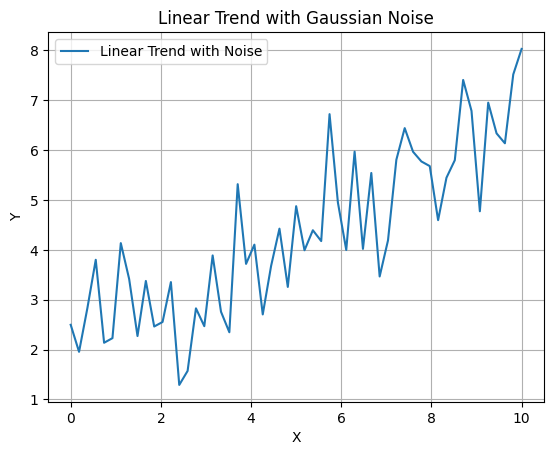

In [4]:
# Plot the linear trend with noise
plt.plot(x, linear_trend_with_noise, label='Linear Trend with Noise')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Trend with Gaussian Noise')
plt.legend()
plt.grid()
plt.show()

In [5]:
# Create a DataFrame from a dictionary
data_ele = {'Date': [i for i in range(55)],
        'Close': linear_trend_with_noise,}

data = pd.DataFrame(data_ele).to_numpy()
data

array([[ 0.        ,  2.49671415],
       [ 1.        ,  1.95432829],
       [ 2.        ,  2.83287372],
       [ 3.        ,  3.80080763],
       [ 4.        ,  2.136217  ],
       [ 5.        ,  2.22882601],
       [ 6.        ,  4.13476837],
       [ 7.        ,  3.41558288],
       [ 8.        ,  2.27126635],
       [ 9.        ,  3.37589338],
       [10.        ,  2.46250823],
       [11.        ,  2.55278876],
       [12.        ,  3.35307338],
       [13.        ,  1.29042346],
       [14.        ,  1.57137846],
       [15.        ,  2.82660136],
       [16.        ,  2.46865036],
       [17.        ,  3.88832141],
       [18.        ,  2.75864259],
       [19.        ,  2.34695556],
       [20.        ,  5.31750062],
       [21.        ,  3.71866814],
       [22.        ,  4.10456524],
       [23.        ,  2.70488144],
       [24.        ,  3.6778395 ],
       [25.        ,  4.4257374 ],
       [26.        ,  3.25641383],
       [27.        ,  4.87569802],
       [28.        ,

In [6]:
train_set = data[:len(data)-5]
test_set = data[-5:]

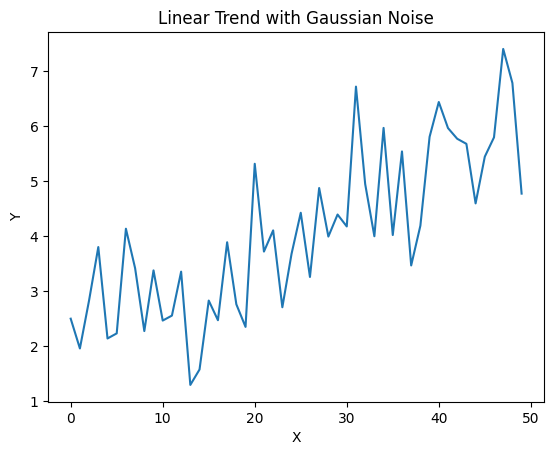

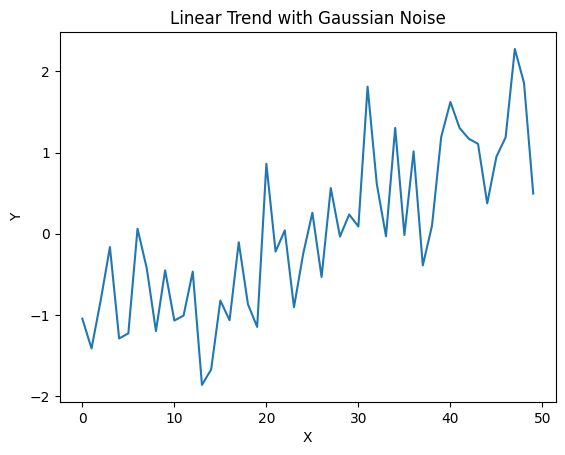

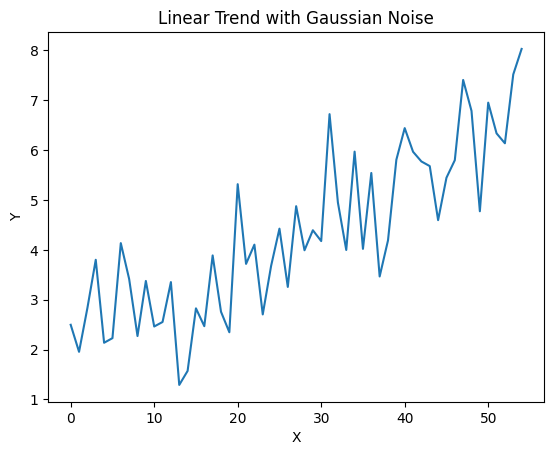

In [9]:
# Plot the data

# Extract X, Y coordinates
x1 = train_set[:, 0]
y1 = train_set[:, 1]

# Extract X, Y coordinates
xt = test_set[:, 0]
yt = test_set[:, 1]

# STNDARDISING THE DATA

av = sum(y1)/len(y1)
av2 = np.sqrt(sum(y1*y1)/len(y1) - av*av)

y2 = (y1-av)/av2

# Reshape the data and subtract average from y data
x = np.reshape(x1, (len(np.unique(x1)), 1))
y = np.reshape(y2, (len(np.unique(x1))))

# PLOTTING THE ORIGINAL AND STANDRADISED DATA
plt.plot(x,y1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Trend with Gaussian Noise')
plt.show()
plt.plot(x,y2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Trend with Gaussian Noise')
plt.show()
plt.plot(data[:, 0], data[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Trend with Gaussian Noise')
plt.show()

# Gaussian Process Regression

##Optimize model parameters via maximum marginal likelihood:

In this research, we employed gradient descent, specifically the Adam optimiser, to learn both the kernel parameters and the observation noise variance. This optimization process was conducted on the maximum marginal likelihood.

## Exponentiated Quadratic Kernel without Noise
We first apply the squared exponential kernel without noise to the data.

In [10]:
tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

Step 0: NLL = 293.3583544209003
Step 100: NLL = 111.75101902407917
Step 200: NLL = 111.71448940756676
Step 300: NLL = 111.71448930388777
Step 400: NLL = 111.71550238082432
Step 500: NLL = 111.71456005859693
Step 600: NLL = 111.71475943797225
Step 700: NLL = 111.71479580885574
Step 800: NLL = 111.72476865734251
Step 900: NLL = 111.71485995433721
Step 1000: NLL = 111.72584319347908
Step 1100: NLL = 111.75884821270654
Step 1200: NLL = 111.86316056735967
Step 1300: NLL = 111.71812517336986
Step 1400: NLL = 111.71467194363609
Step 1500: NLL = 111.71533481979213
Step 1600: NLL = 111.71486752002713
Step 1700: NLL = 111.71457898807836
Step 1800: NLL = 111.71511978489283
Step 1900: NLL = 111.71457143160288
Final NLL = 111.71487089601644


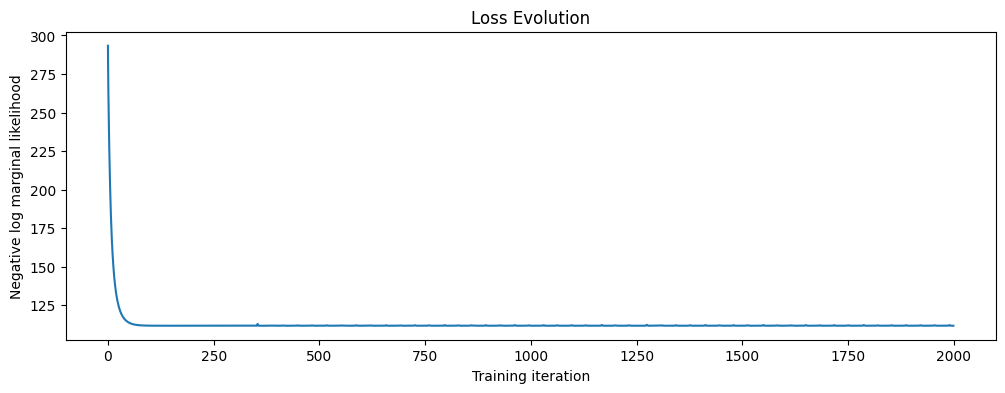

<function matplotlib.pyplot.show(close=None, block=None)>

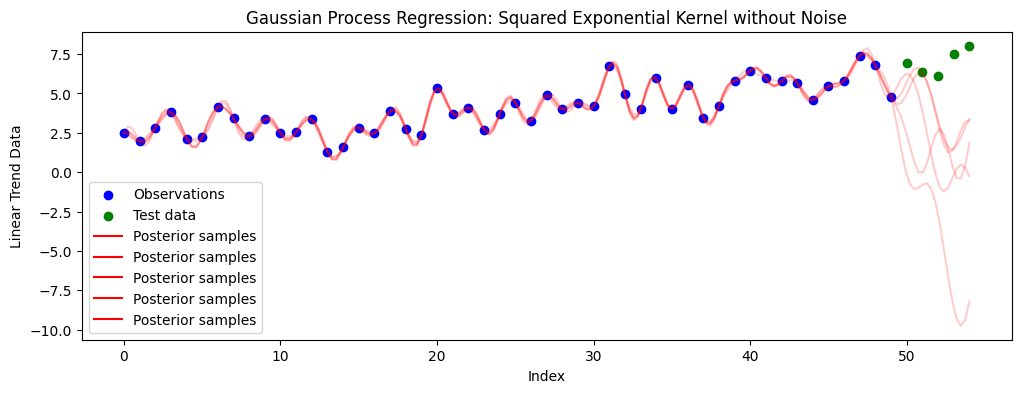

In [11]:
# We build the observations to be a function f(x) where f(x) is the target values (Linear Trend Data) and x is the index.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define a kernel with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Noise-free observation
observation_noise_variance = 0.0

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

# The parameters beta_1 and beta_2 are the exponential decay rates for
# the first and second moments of the gradient, respectively.
# They control the weight given to past gradients and squared gradients
# in the parameter updates.
optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [54, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain 5 posterior samples.
samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential Kernel without Noise')
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='lower left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Index")
plt.ylabel("Linear Trend Data")
plt.show

In [12]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
para.append(('observation_noise_variance', np.array(observation_noise_variance)))
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara

,Hyperparameters,Value
0,amplitude,3.5409452023462427
1,length_scale,1.0971029124362244
2,observation_noise_variance,0.0


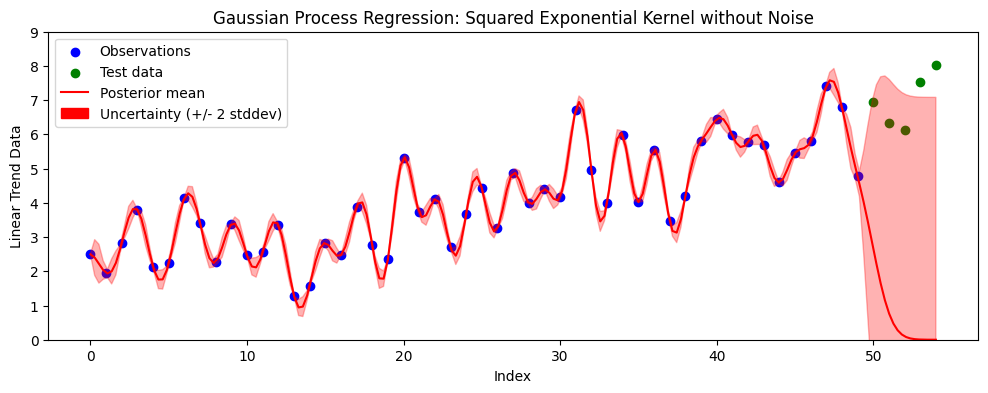

In [13]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.ylim(0,9)
plt.title('Gaussian Process Regression: Squared Exponential Kernel without Noise')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Index")
plt.ylabel("Linear Trend Data")
plt.show()

The posterior mean convergence of the Gaussian process regression model, utilizing a squared exponential kernel without noise, tends to approach zero on the test inputs. Despite this limitation, the kernel remains well-suited for interpolation purposes, especially in scenarios involving the filling or imputation of missing data gaps.

## Exponentiated Quadratic Kernel with Noise
Now, a noise was added to the squared exponential kernel and the observations.

Step 0: NLL = 287.72964302323436
Step 100: NLL = 111.65209825103341
Step 200: NLL = 80.73268204361483
Step 300: NLL = 73.14881153474595
Step 400: NLL = 73.02311423692862
Step 500: NLL = 72.99059842397925
Step 600: NLL = 72.98341800786373
Step 700: NLL = 72.98256604044784
Step 800: NLL = 72.98253724002339
Step 900: NLL = 72.98253717413547
Step 1000: NLL = 72.98254728476594
Step 1100: NLL = 72.98284258835562
Step 1200: NLL = 72.98271993345716
Step 1300: NLL = 72.98253836231905
Step 1400: NLL = 72.98253713443981
Step 1500: NLL = 72.98253713205762
Step 1600: NLL = 72.98253713202048
Step 1700: NLL = 72.98253713201476
Step 1800: NLL = 72.98253713201458
Step 1900: NLL = 72.9825371320145
Final NLL = 72.9825371320145


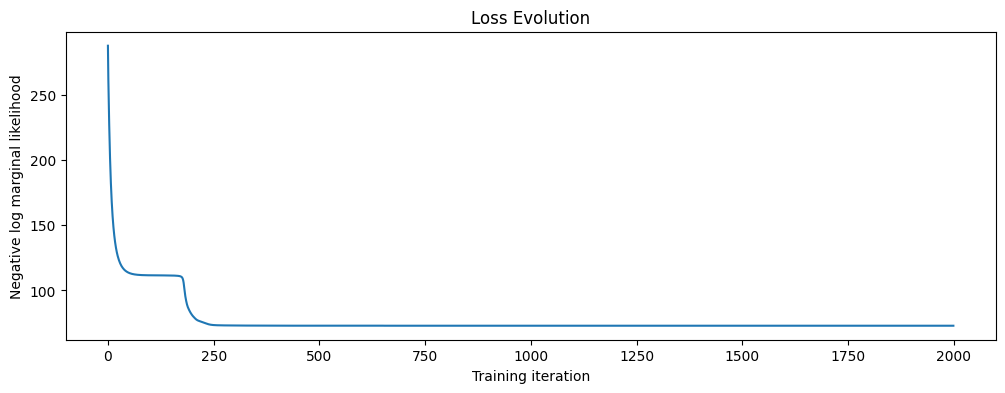

<function matplotlib.pyplot.show(close=None, block=None)>

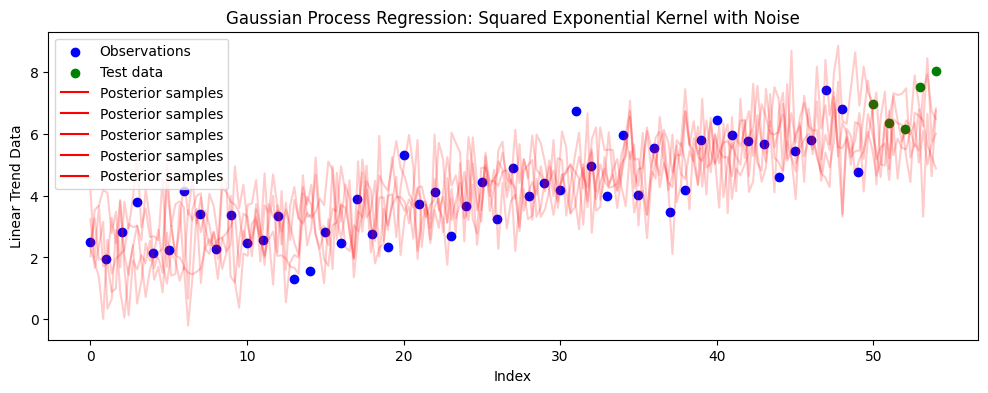

In [26]:
# Suppose we have some data from a known function. Note the index points in
# general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one
# here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define a kernel with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Noisy observation
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optomised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [54, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain 5 posterior samples.
samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential Kernel with Noise')
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Index")
plt.ylabel("Linear Trend Data")
plt.show

In [27]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara

,Hyperparameters,Value
0,amplitude,4.8334695809711095
1,length_scale,55.309946783810844
2,observation_noise_variance,0.8388090411709562


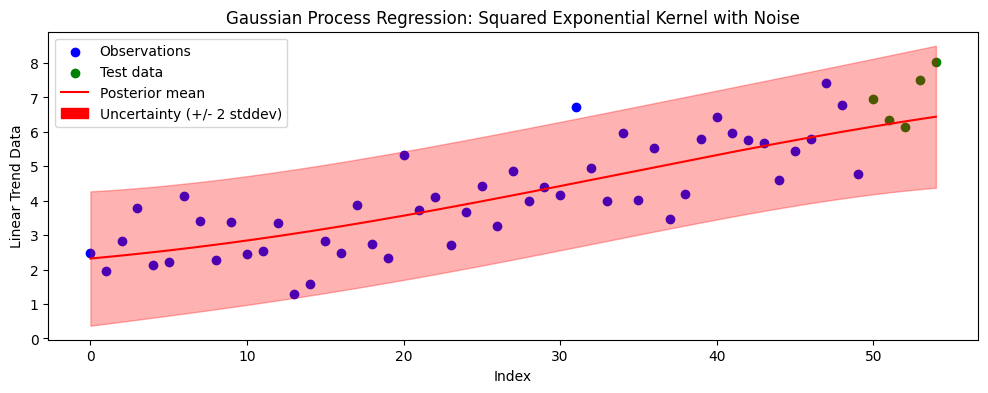

In [28]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
# plt.ylim(0, tf.reduce_max(mean_prediction + 2*prediction_stddev).numpy()+2)
plt.title('Gaussian Process Regression: Squared Exponential Kernel with Noise')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Index")
plt.ylabel("Linear Trend Data")
plt.show()

Let's expand the analysis to observe the behavior of the Day variable and its corresponding converging values in more detail.

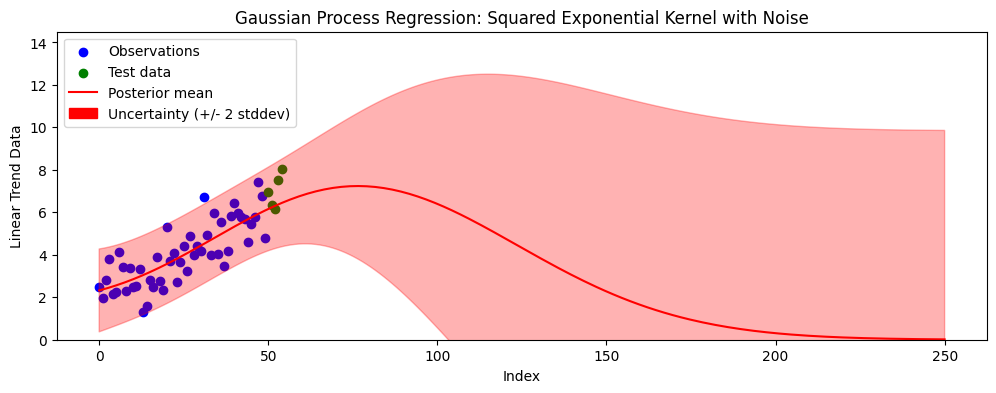

In [29]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optomised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 250, 200, dtype=np.float64)
# Reshape to [250, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.ylim(0, tf.reduce_max(mean_prediction + 2*prediction_stddev).numpy()+2)
plt.title('Gaussian Process Regression: Squared Exponential Kernel with Noise')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Index")
plt.ylabel("Linear Trend Data")
plt.show()

The graph illustrates that the posterior mean of the Gaussian process regression model, employing a squared exponential kernel with noise, also converges to 0 on the test inputs.

## Exponentiated Quadratic Kernel with Linear Trends and Noise
We combined the squared exponential kernel with linear covariance function and noise to the noisy observations.

Step 0: NLL = 116.81344594963795
Step 100: NLL = 72.14615729913459
Step 200: NLL = 72.05882068565072
Step 300: NLL = 72.05438077831951
Step 400: NLL = 72.0537637698284
Step 500: NLL = 72.05349088614375
Step 600: NLL = 72.05334384739986
Step 700: NLL = 72.05326059462537
Step 800: NLL = 72.05321212728188
Step 900: NLL = 72.05319395294183
Step 1000: NLL = 72.05388324297915
Step 1100: NLL = 72.0599091132243
Step 1200: NLL = 72.05332291853117
Step 1300: NLL = 72.05325059187402
Step 1400: NLL = 72.05314387033812
Step 1500: NLL = 72.05314226818761
Step 1600: NLL = 72.05330857239477
Step 1700: NLL = 72.07983441956091
Step 1800: NLL = 72.05315447753964
Step 1900: NLL = 72.05314111391164
Final NLL = 72.05314024936267


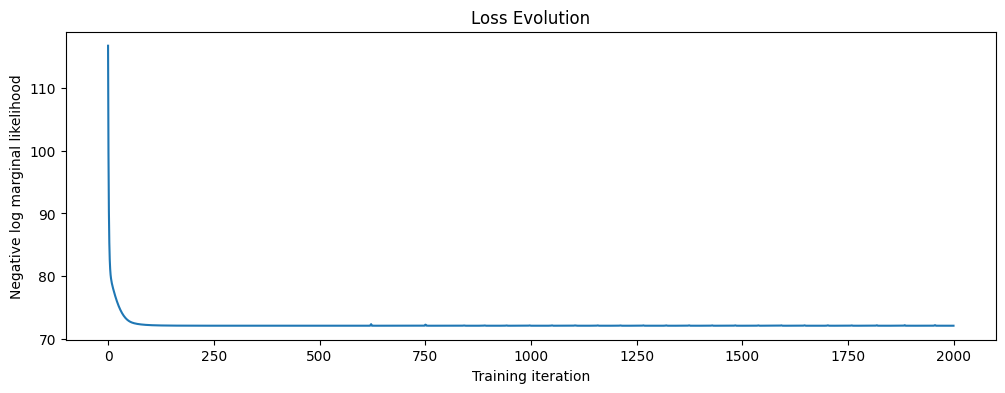

<function matplotlib.pyplot.show(close=None, block=None)>

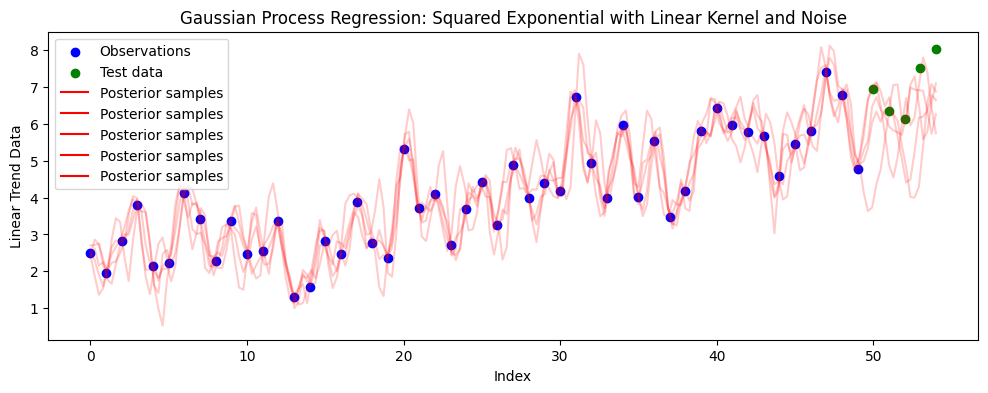

In [41]:
# Suppose we have some data from a known function. Note the index points in
# general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one
# here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define kernels with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.

# Squared exponential kernel
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_RBF = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Linear kernel
bias_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='bias_amplitude')
slope_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='slope_amplitude')
shift = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='shift')
kernel_linear = tfp.math.psd_kernels.Linear(bias_amplitude,slope_amplitude,shift)

# Combine the kernels together.
kernel = kernel_RBF+kernel_linear

# Noise kernel
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [54, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential with Linear Kernel and Noise')
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Index")
plt.ylabel("Linear Trend Data")
plt.show

In [42]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    bias_amplitude,
    slope_amplitude,
    shift,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

,Hyperparameters,Value
0,amplitude,0.9205954456131391
1,length_scale,0.41599300830375163
2,bias_amplitude,2.078726899970879
3,slope_amplitude,0.08102693382926028
4,shift,4.8870176837386846e-06
5,observation_noise_variance,0.015498290713391781


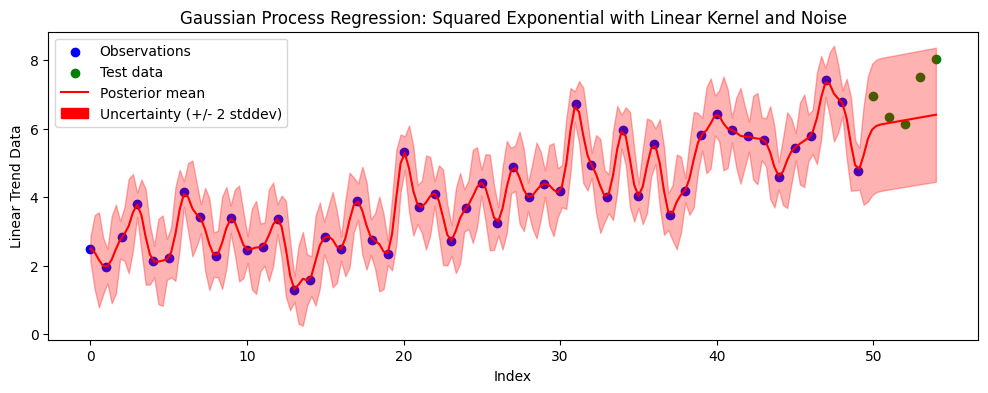

In [43]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential with Linear Kernel and Noise')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Index")
plt.ylabel("Linear Trend Data")
plt.show()

To gain a more detailed understanding, let's extend the analysis, observing its behavior and the corresponding converging values in further test inputs.

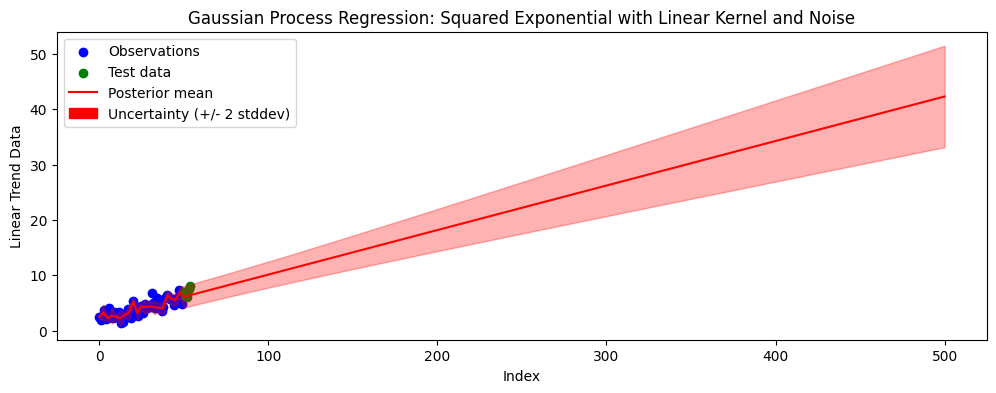

In [44]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optomised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 500, 200, dtype=np.float64)
# Reshape to [500, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
# plt.ylim(0, tf.reduce_max(mean_prediction + 2*prediction_stddev).numpy()+2)
plt.title('Gaussian Process Regression: Squared Exponential with Linear Kernel and Noise')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Index")
plt.ylabel("Linear Trend Data")
plt.show()

It can be seen that the posterior mean exhibits a continuous increase, unlike the scenarios without the incorporation of the linear kernel.